In [1]:
# some imports
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf

assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
# % matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Others
import cv2
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from skimage.io import imread
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import util.Display_images as display

In [2]:
import winsound
def beep():
    winsound.Beep(500, 2000)

 ## Import data


In [3]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [2]:
# Paths
X_train_path = './dataset/train/train/train/'
X_test_path = './dataset/test/test/test/'
dataset_csv = './dataset/train.txt'
dataset_csv_test = './dataset/test.txt'
dataset_train = './dataset/train/train'
dataset_test = './dataset/test/test'


In [3]:
_STOP = 1000


def preprocess(img_paths, dataset_path, preprocess_img_method=None):
    print("loading data")
    data = []
    stop = 0
    for img_path in tqdm.tqdm(img_paths):
        path = os.path.realpath(os.path.join(dataset_path, img_path[1:]))
        img = cv2.imread(path)
        if preprocess_img_method:
            img = preprocess_img_method(img)
        else:
            img = cv2.resize(img,(224,224),cv2.INTER_AREA)
            img = img / 255.  #normalize
        data.append(img)
        stop += 1
        if (stop == _STOP):
            break
    print("loading data done")
    return data


def preprocess_img_vgg(img):
    return preprocess_input(img)


In [4]:
df = pd.read_csv(dataset_csv, delimiter='\ ', header=None)
y_train_full = np.array(df[1])[:_STOP]
img_paths = df[0]
X_train_full = preprocess(df[0], dataset_train, preprocess_img_method=None)
X_train_full = np.stack(X_train_full)

C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


loading data


  7%|▋         | 999/15000 [00:00<00:10, 1310.56it/s]


loading data done


In [5]:
no_classes = np.max(y_train_full) + 1

In [6]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42, test_size=0.1)
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
y_train = y_train.astype("float32")
y_valid = y_valid.astype("float32")
# X_valid_test = np.array([x[np.newaxis,:,:] for x in X_valid])
X_valid_test = X_valid
y_valid_test = y_valid

In [7]:
print(X_train[:10].shape)
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))
print(len(X_train))
print(X_train[0].shape)
print(type(X_train))
print(X_train.shape)

print(type(X_train[0]))
print(y_train[:10])

(10, 224, 224, 3)
900
900
100
100
900
(224, 224, 3)
<class 'numpy.ndarray'>
(900, 224, 224, 3)
<class 'numpy.ndarray'>
[13. 25.  8. 25. 10. 23. 12. 15. 12. 28.]


In [ ]:
print(X_train.shape[1:])

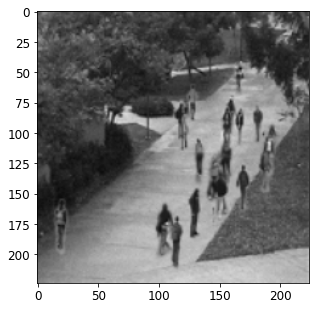

In [7]:
plt.imshow(X_train[1], cmap='gray')

In [8]:
img_flipped_left_right = tf.image.random_flip_left_right(X_train[1])
img_flipped_up_down = tf.image.flip_up_down(X_train[1])
img_rot90 = tf.image.rot90(X_train[1])

aug_imgs=[img_flipped_left_right,img_flipped_up_down,img_rot90]
img_titles = ["Img flipped left right", "Img flipped top down","Img rotated 90"]

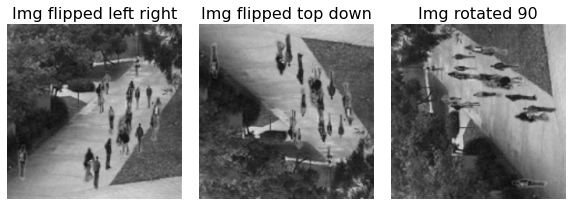

In [14]:
display.display_multiple_images(images=[aug_imgs],titles=[img_titles],
                                figure_size=(10,10))

## Model

In [19]:
def get_uncompiled_model():
    model = tf.keras.applications.vgg16.VGG16(include_top=True,weights='imagenet',input_tensor=None,input_shape=(224,224,3),pooling=None,classifier_activation='softmax')

    for layer in model.layers:
        if layer.name.startswith("fc2"):
            continue
        layer.trainable = False
    last_layer = model.get_layer('fc2').output
    out = tf.keras.layers.Flatten(name="flatten1")(last_layer)
    out = tf.keras.layers.Dense(128, activation='relu', name='fc3')(out)
    out = tf.keras.layers.Dropout(0.5)(out)
    out = tf.keras.layers.Dense(1, activation='linear', name='prediction')(out)
    model = tf.keras.models.Model(inputs=model.input, outputs=out)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    nadam = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)
    rmse = rmse_loss
    model.compile(
        optimizer=nadam,  # Optimizer
        # Loss function to minimize
        loss=rmse,
        # List of metrics to monitor
        metrics=["accuracy", root_mean_squared_error]
    )
    return model

#TODO
# model = keras.models.Sequential([conv_encoder, conv_decoder])

In [20]:
def rmse_loss(y_true, y_pred):
    return tf.sqrt((tf.math.reduce_mean(tf.square(tf.cast(y_pred, tf.float64) - tf.cast(y_true, tf.float64)))))

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.cast(tf.math.reduce_mean(tf.square(y_pred - y_true)), tf.float64))

In [21]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        # print(str(y_true)," - " , str(y_pred))
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor

In [22]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt/cc-2-vgg-r"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]

    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


def make_or_restore_model_weights_only_uncompiled():
    model = get_uncompiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest:
        model.load_weights(latest)
        print("Restoring from", latest)
    return model

def make_or_restore_model_weights_only_compiled():
    model = get_compiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest:
        model.load_weights(latest)
        print("Restoring from", latest)
    return model

def restore_model():
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)


def restore_model_weights_only():
    model = get_uncompiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print("Restoring from", latest)
    model.load_weights(latest)
    return model


def restore_model_weights_only_uncompiled():
    model = get_uncompiled_model()
    # checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print("Restoring from", latest)
    model.load_weights(latest)
    return model


### Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40)
###

### Model saving
model_saving = keras.callbacks.ModelCheckpoint(
    # Path where to save the model
    # The two parameters below mean that we will overwrite
    # the current checkpoint if and only if
    # the `val_loss` score has improved.
    # The saved model name will include the current epoch.
    filepath=checkpoint_dir + "/val_loss={val_loss:.3f}_loss={loss:.3f}_rmse={val_root_mean_squared_error:.3f}_ckpt={epoch}",
    save_best_only=True,  # Only save a model if `val_loss` has improved.
    monitor="val_root_mean_squared_error",
    save_weights_only=True,
    mode="min",
    verbose=1,
)
###

### init callbacks
callbacks = [
    model_saving,
    early_stopping
]


In [31]:
# model = get_compiled_model()
model = make_or_restore_model_weights_only_uncompiled()
# model = get_uncompiled_model()

MemoryError: Unable to allocate 392. MiB for an array with shape (25088, 4096) and data type float32

In [24]:
model.get_layer("fc1").trainable=True

In [25]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [26]:
# optimizer
adam = tf.keras.optimizers.Adam(lr=1e-4)
rmsprops = tf.keras.optimizers.RMSprop(lr=0.0005, rho=0.9)
nadam = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)#0.0005
sgd = tf.keras.optimizers.SGD(lr=1e-5, decay=(1 * 1e-5), momentum=0.95, nesterov=True)

# LOSS
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
rmse = rmse_loss
model.compile(
    optimizer=nadam,  # Optimizer
    # Loss function to minimize
    loss=rmse,
    # List of metrics to monitor
    metrics=[root_mean_squared_error]
)
# model.compile(optimizer=sgd, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[root_mean_squared_error,'accuracy'])#['accuracy','mse'])
# model.compile(optimizer=sgd, loss=root_mean_squared_error, metrics=[root_mean_squared_error,'accuracy'])#['accuracy','mse'])
# model.compile(optimizer=sgd, loss=root_mean_squared_error, metrics=['loss'])#['accuracy','mse'])

In [30]:
print("Fit model on training data")
history = model.fit(
    X_train_full,
    y_train_full,
    batch_size=16,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # validation_data=(X_valid, y_valid),
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks
)
pd.DataFrame(history.history).plot(figsize=(8, 5))

Fit model on training data


MemoryError: Unable to allocate 5.83 GiB for an array with shape (10400, 224, 224, 3) and data type float32

# Tests

In [9]:
# TEST RMSE for best model
model = restore_model_weights_only()  # Restore Model
n = len(y_valid_test)
preds = model.predict(X_valid_test)
preds = [item for sublist in preds for item in sublist]
# preds = np.array([np.rint(pred) for pred in preds])
preds = np.array(preds)
vals = np.array(y_valid_test[:n])
rmse = [np.sqrt(np.sum(np.square(preds[:n] - vals[:n])) / n)]
print(rmse)
beep()

NameError: name 'restore_model_weights_only' is not defined

In [227]:
print(rmse)



[1.216754442645646]


In [ ]:
# Save Model

In [230]:
model.save('./ckpt/full_saves/2-complex-regression/', save_format='tf')

INFO:tensorflow:Assets written to: ./ckpt/full_saves/2-complex-regression/assets


In [ ]:
model = tf.keras.models.load_model('./ckpt/full_saves/2-complex-regression/')

In [34]:
## TEST restore weights
model = make_or_restore_model_weights_only_compiled()
# Re-evaluate the model
loss, rmse = model.evaluate(X_valid, y_valid, verbose=2)
print("Restored model, rmse: {:.5f}".format(rmse))

Restoring from ./ckpt/cc-2-complex-r\val_loss=1.091_loss=1.969_rmse=1.090_ckpt=25
47/47 - 1s - loss: 0.8316 - accuracy: 0.0627 - root_mean_squared_error: 0.8317
Restored model, rmse: 0.83168


## Submission

In [35]:
# Submission
df_test = pd.read_csv(dataset_csv_test, delimiter='\ ', header=None)
print(df_test)

                                     0
0    /test/test_composite000000001.png
1    /test/test_composite000000000.png
2    /test/test_composite000000002.png
3    /test/test_composite000000003.png
4    /test/test_composite000000004.png
..                                 ...
495  /test/test_composite000000495.png
496  /test/test_composite000000496.png
497  /test/test_composite000000497.png
498  /test/test_composite000000498.png
499  /test/test_composite000000499.png

[500 rows x 1 columns]


C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [36]:
X_test_full = preprocess(df_test[0], dataset_test, preprocess_img_method=None)
X_test_full = np.stack(X_test_full)

loading data


100%|██████████| 500/500 [00:00<00:00, 997.10it/s] 

loading data done


In [37]:
#Predict
predictions = model.predict(X_test_full)
predictions = [item for sublist in predictions for item in sublist]
# predictions = [int(np.rint(pred)) for pred in preds]

In [38]:
print(predictions)

[23.104956, 22.147179, 13.255741, 26.912169, 22.992123, 12.771068, 27.109512, 23.531567, 0.62465507, 7.9170113, 18.011591, 2.3918018, 4.021, 21.983608, 16.2632, 5.451976, 7.9302464, 2.1475017, 26.029644, 14.791932, 3.8816683, 18.720945, 24.918594, 14.73671, 15.501097, 0.040252447, 5.3421164, 1.9091277, 8.20919, 2.551167, 9.000661, 22.820261, 13.101628, 18.101559, 26.093458, 0.2397139, 14.7401285, 9.58356, 2.4810343, 5.335267, 14.815718, 16.429562, 5.9750586, 26.176294, 15.724877, 19.60168, 15.648695, 27.993084, 2.1956823, 19.197054, 24.066307, 3.324585, 22.377525, 7.2528257, 1.2530948, 25.66039, 4.6987104, 12.634041, 19.280157, 27.984602, 20.509478, 19.950867, 20.898098, 2.0016391, 3.942071, 12.945761, 0.4554028, 2.2232268, 9.1856785, 11.819566, 20.626448, 1.5275627, 0.1534468, 10.2901945, 29.335464, 8.335817, 7.931485, 14.238179, 11.704199, 24.702953, 5.800662, 19.46589, 28.292034, 23.520826, 1.9492885, 21.427046, 26.092678, 28.556902, 22.680014, 21.41565, 20.877901, 21.982618, 30.102

In [39]:
indexes = []
for i in range(len(predictions)):
    indexes.append(i)

In [40]:
print(indexes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [41]:
import pandas

df = pandas.DataFrame(data={"index": indexes, "prediction": predictions})
df.to_csv("./sub-2-c-r.csv", sep=',', index=False)